The transfer function for the causal LTI system with a realization $(A, B, C, D)$ is given by
\begin{equation*}
    H(s) = C(sI_{n} - A)^{-1}B.
\end{equation*}
Notice that $H(s) = Cv(s)$, where $v(s)$ is the solution of a parametrized linear coercive model
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$. In other words, we replace the matrix computation of $(sI_{n} - A)^{-1}B$ with a parametrized model (1). However, if one wants to apply this to the Iterative rational Krylov algorithm (IRKA), then the following matrix computations must be done to construct the projection matrices $V$ and $W$:
\begin{equation*}
    (-\mu_{i}I_{n} - A)^{-1}B\hat{b}_{i}, \quad \text{and} \quad (-\mu_{i}I_{n} - A)^{-*}C^{T}\hat{c}_{i} \quad \text{for } i = 1,\ldots,r,
\end{equation*}
where $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i}$ are some initial interpolation data and $0 < r \leq n$ is the desired order of approximating ROM. So, we have decided to solve two parametrized linear coercive models to construct projection matrices $V$ and $W$:
\begin{equation}
    a_{1}(v_{1}, w; s) = l_{1}(w) \quad \text{and} \quad a_{2}(v_{2}, w; s) = l_{2}(w),
\end{equation}
where $a_{1}(v_{1}, w; s) = w^{*}(sI_{n} - A)v_{1}$ and $l_{1}(w) = w^{*}B$, and $a_{2}(v_{2}, w; s) = w^{*}(sI_{n} - A)^{*}v_{2}$ and $l_{2}(w) = w^{*}C^{T}$, and solutions to these parametrized linear coercive models are
\begin{equation*}
    v_{1}(s) = (sI_{n} - A)^{-1}B \quad \text{and} \quad v_{2}(s) = (sI_{n} - A)^{-*}C^{T}.
\end{equation*}
Therefore, knowing $v_{1}(\mu_{i})$ and $v_{2}(\mu_{i})$ for $i = 1, \ldots, r$ will suffice for constructing the projection matrices $V$ and $W$. Also, note that these two FOMs are parameter-separable, i.e.,
\begin{equation*}
    a_{1}(v_{1},w;s) = w^{*}(sI_{n} - A)v_{1} = sw^{*}I_{n}v_{1} - w^{*}Av_{1}  \quad  a_{2}(v_{2},w;s) = w^{*}(sI_{n} - A)^{*}v_{2} = \overline{s}w^{*}I_{n}v_{2} - w^{*}A^{*}v_{2}.
\end{equation*}

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, norm
from pymor.basic import *
from pymor.models.basic import StationaryModel
from pymor.operators.constructions import LincombOperator
from pymor.operators.numpy import NumpyMatrixOperator
from pymor.parameters.functionals import ProjectionParameterFunctional, ConjugateParameterFunctional
from pymor.vectorarrays.numpy import NumpyVectorSpace

### Constructing a stationary model
Let us construct a stationary model of the following parametrized linear coercive model using `pyMOR`:
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$.

In [52]:
def MatrixModel(A, B):

    '''
    This function create a stationary model of the following linear coercive model derived for the given two matrices A and B:
    
        a(v, w; s) =w^{*}(sI_{n} - A)v and l(w) = w^{*}B.
    '''

    # Define NumpyMatrixOperators
    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        dim = A.shape[0]
        A_op = NumpyMatrixOperator(A)
        B_op = NumpyMatrixOperator(B) # B.shape = (-,1) 
    else:
        dim = to_matrix(A).shape[0]
        A_op = A
        B_op = B 

    I_op = NumpyMatrixOperator(np.eye(dim))

    # Define parameter functional for 's'
    s_param = ProjectionParameterFunctional('s', 1)

    # Define bilinear form a(v, w; s) = w^* (sI - A)v
    a_op = LincombOperator([I_op, A_op], [s_param, -1])

    # Define linear functional l(w) = w^*B
    l_op = B_op

    # Define the StationaryModel
    model = StationaryModel(operator = a_op, rhs = l_op)

    return model

### Examples
Notice that to make this process more convenient, we provide two options for input matrices. If one has the matrices as `NumPy` arrays, they can import them directly without changing their type to work with `pyMOR`. Additionally, if one wants to input matrices from existing `pyMOR` models, this can also be done directly. To demonstrate this, we provide two examples: one with random matrices that we construct ourselves, and the other with matrices imported from the `penzl_example` in `pymor.models.examples`.


In [53]:
# Stationary model constructed using random numpy arrays

# Randomly generated arrays
np.random.seed(127)
matrixA = np.random.rand(20, 20) # A is 20x20 matrix
matrixB = np.random.rand(20).reshape(20,1) # B is 20x1 vector

model_numpy = MatrixModel(A = matrixA, B = matrixB)
model_numpy

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True)

In [54]:
# Set parameter for evaluation
parameter = {'s': 1.4}  # s = 1.4

# Solve the model
solution = model_numpy.solve(parameter).to_numpy()

# Exact matrix computation
exact = (inv(parameter['s']*np.eye(20) - matrixA)@matrixB).reshape(1, 20)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The exact value of the matrix computation (1.4I - A)^{-1}B is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The L-infinity error is 2.4424906541753444e-15.


In [55]:
# Stationary model constructed using matrices obtained from penzl example
from pymor.models.examples import penzl_example

penzl = penzl_example()

model_penzl = MatrixModel(penzl.A, penzl.B)
model_penzl

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<1006x1006 dense>), NumpyMatrixOperator(<1006x1006 sparse, 1012 nnz>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<1006x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(1006)),
    products={},
    output_d_mu_use_adjoint=True)

In [56]:
from pymor.algorithms.to_matrix import to_matrix

# Set parameter for evaluation
parameter = {'s': -1 + 2*1j}  # s = - 1 + 2i

# Solve the model
solution = model_penzl.solve(parameter).to_numpy()

# Exact matrix computation
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

exact = (inv(parameter['s']*np.eye(penzl.order) - matrixA)@matrixB).reshape(1, penzl.order)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The exact value of the matrix computation ((-1+2j)I - A)^{-1}B is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The L-infinity error is 2.7755575615628914e-17.


## Reduced Basis Methods

As an example, we will use `penzl_example` from `pymor.models.examples` to construct a reduced basis using the reduced basis methods available in `pyMOR`.

In [57]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B)

### POD-Galerkin Method

In [58]:
# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a training set
training_set = parameter_space.sample_randomly(50)

# Compute FOM solutions for the parameters in the training set
solution_snapshots = model_penzl.solution_space.empty()
for s in training_set:
    solution_snapshots.append(model_penzl.solve(s))

# Snapshot matrix S
snapshot_matrix = solution_snapshots.to_numpy().T
print(f'An {snapshot_matrix.shape[0]} by {snapshot_matrix.shape[1]} snapshot matrix is \n {snapshot_matrix}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

An 1006 by 50 snapshot matrix is 
 [[ 0.10791712  0.10508859  0.10858926 ...  0.1037334   0.10717139
   0.10234687]
 [-0.09056608 -0.09433111 -0.08958912 ... -0.09596436 -0.09161048
  -0.0975374 ]
 [ 0.05208595  0.05131127  0.05227672 ...  0.05095332  0.05187756
   0.05059421]
 ...
 [ 0.00099429  0.00099761  0.00099346 ...  0.00099911  0.0009952
   0.00100059]
 [ 0.0009933   0.00099662  0.00099247 ...  0.00099811  0.00099421
   0.00099959]
 [ 0.00099232  0.00099562  0.00099149 ...  0.00099712  0.00099322
   0.0009986 ]]


In [59]:
# Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True) # using 'pod_basis, pod_singular_values = pod(solution_snapshots)' gives wrong result (pod_basis._len != 10 (5 != 10)); that's why we don't use it here. 

# Activate below to automatically select the number of modes based on the energy criterion
## The number of modes m should be chosen based on the energy criterion, which ensures that a sufficient portion of the system's total energy (or variance) is captured by the first m modes.
#cumulative_energy = np.cumsum(D**2) / np.sum(D**2)

##Select the number of modes m to capture at least 95% of the energy
#threshold = 0.95  # 95% of the total energy
#m = np.argmax(cumulative_energy >= threshold) + 1

m = 20 # this is also a reduction order

if m > min(snapshot_matrix.shape):
    raise ValueError("m cannot exceed the rank of the snapshot matrix.")

# The reduced basis (POD basis)
pod_basis_numpy = U[:,:m]
print(f'The reduced basis (containing the first {m} left singular vectors (POD modes) of the snapshot matrix as its columns) is \n {pod_basis_numpy}')

The reduced basis (containing the first 20 left singular vectors (POD modes) of the snapshot matrix as its columns) is 
 [[-0.19696096 -0.31340348  0.36198988 ... -0.00431519 -0.00049817
   0.00223207]
 [ 0.17630327  0.23589406 -0.16498272 ... -0.0379153  -0.02853059
   0.00898774]
 [-0.09617923 -0.14845524  0.1618159  ...  0.36862449  0.29847176
  -0.06855028]
 ...
 [-0.0018688  -0.00275277  0.0026819  ... -0.0157844   0.00189082
  -0.00276168]
 [-0.00186694 -0.00275005  0.00267931 ... -0.00445315 -0.0062538
  -0.00233055]
 [-0.00186508 -0.00274733  0.00267672 ...  0.00197302 -0.00953304
   0.00471574]]


In [60]:
from pymor.reductors.basic import StationaryRBReductor

# Convert NumPy array into VectorArray 
'''
The two lines below are the correct way to convert a NumPy reduced basis array into a VectorArray. However, the 'StationaryRBReductor' raises an error because 
'pod_basis in model_penzl.solution_space' is set to False. This happens because 'pod_basis.dim' is not equal to 'model_penzl.solution_space.dim'. This is 
expected since pod_basis.dim equals m (the number of modes, which can vary and is not fixed), whereas model_penzl.solution_space.dim is a fixed integer.
'''
#space = NumpyVectorSpace(m)
#pod_basis = space.make_array(pod_basis_numpy)

space = NumpyVectorSpace(model_penzl.order)
pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

# POD-Galerkin RB method
pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
pod_rom = pod_reductor.reduce()
pod_rom

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True,
    name='StationaryModel_reduced')

In [61]:
import time

# Start timing
start_time_reduce = time.time()

# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a validation set
r = 10
validation_set = parameter_space.sample_randomly(r)

# Solution array containing r many reduced samples
reduced_solution = pod_rom.solution_space.empty()
for s in validation_set:
    reduced_solution.append(pod_rom.solve(s))

# End timing
end_time_reduce = time.time()

# Compute and print the elapsed time
elapsed_time_reduce = end_time_reduce - start_time_reduce

# Reconstruct high-dimensional vector from reduced vector (necessary for error analysis)
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

print(f'The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is \n {reduced_solution_reconstruct}')

The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is 
 [[ 0.10291402 -0.09690529  0.0507403  ...  0.00099999  0.00099899
   0.000998  ]
 [ 0.10107168 -0.09890484  0.05026941 ...  0.00100192  0.00100092
   0.00099992]
 [ 0.10802123 -0.09041703  0.05211531 ...  0.00099416  0.00099318
   0.00099219]
 ...
 [ 0.1062161  -0.09289231  0.05161515 ...  0.00099632  0.00099533
   0.00099434]
 [ 0.1023473  -0.09753694  0.05059432 ...  0.00100059  0.00099959
   0.0009986 ]
 [ 0.10210677 -0.09780046  0.05053268 ...  0.00100085  0.00099985
   0.00099885]]


In [62]:
## Exact matrix computation

# Start timing
start_time_exact = time.time()

matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# End timing
end_time_exact = time.time()

# Compute and print the elapsed time
elapsed_time_exact = end_time_exact - start_time_exact

In [63]:
## Error analysis

# Start timing
start_time_full = time.time()

# FOM solution
full_solution = model_penzl.solution_space.empty()
for s in validation_set:
    full_solution.append(model_penzl.solve(s))
    
# End timing
end_time_full = time.time()

# Compute and print the elapsed time
elapsed_time_full = end_time_full - start_time_full

# Convert FOM solution into NumPy array
full_solution_numpy = full_solution.to_numpy()

# ROM solution
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()

# Norms for each training data - > output is an array
error_exact = exact_solution - reduced_solution_reconstruct_numpy
error_fom = full_solution_numpy - reduced_solution_reconstruct_numpy
num_rows = error_exact.shape[0]
linfnorm_exact = np.zeros(num_rows)
l2norm_exact = np.zeros(num_rows)
linfnorm_fom = np.zeros(num_rows)
l2norm_fom = np.zeros(num_rows)
for row_number in range(num_rows):
    linfnorm_exact[row_number] = np.linalg.norm(error_exact[row_number], np.inf)
    l2norm_exact[row_number] = np.linalg.norm(error_exact[row_number], 2)  
    linfnorm_fom[row_number] = np.linalg.norm(error_fom[row_number], np.inf)
    l2norm_fom[row_number] = np.linalg.norm(error_fom[row_number], 2)  

# Printing error results
print('-'*20 + ' Look below to check if things are going well '+'-'*30)
print(f'[The L-infinity norm] The best is {min(linfnorm_exact)} and worst is {max(linfnorm_exact)}.')
print(f'[The L-2 norm] The best is {min(l2norm_exact)} and worst is {max(l2norm_exact)}.')
print('-'*20 + ' Linf and L2 norms (array) of error vectors '+'-'*30)
print(f'The L-infinity norm of (Exact solution - ROM solution) is {linfnorm_exact}.')
print(f'The L-infinity norm of (FOM solution - ROM solution) is {linfnorm_fom}.')
print(f'The L-2 norm of (Exact solution - ROM solution) is {l2norm_exact}.')
print(f'The L-2 norm of (FOM solution - ROM solution) is {l2norm_fom}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

-------------------- Look below to check if things are going well ------------------------------
[The L-infinity norm] The best is 1.5681900222830336e-15 and worst is 5.55056001161347e-13.
[The L-2 norm] The best is 2.079166373371179e-15 and worst is 9.56338260479398e-13.
-------------------- Linf and L2 norms (array) of error vectors ------------------------------
The L-infinity norm of (Exact solution - ROM solution) is [4.38538095e-15 5.55056001e-13 1.58206781e-15 1.77635684e-15
 1.76247905e-15 1.56819002e-15 2.52575738e-15 2.08166817e-15
 5.77315973e-15 5.82867088e-15].
The L-infinity norm of (FOM solution - ROM solution) is [4.38538095e-15 5.55056001e-13 1.58206781e-15 1.77635684e-15
 1.76247905e-15 1.56819002e-15 2.52575738e-15 2.08166817e-15
 5.77315973e-15 5.82867088e-15].
The L-2 norm of (Exact solution - ROM solution) is [5.56674409e-15 9.56338260e-13 2.07916637e-15 2.38565582e-15
 2.31734901e-15 2.11527765e-15 3.26611924e-15 2.72346172e-15
 7.22076397e-15 7.44129153e-15].
Th

In [64]:
# Computational time analysis (execution time analysis)
print(f'Total computation time of POD-Galerkin ROM: {elapsed_time_reduce:.10f} seconds.')
print(f'Total computation time of FOM: {elapsed_time_full:.10f} seconds.')
print(f'Total computation time of Exact: {elapsed_time_exact:.10f} seconds.')

Total computation time of POD-Galerkin ROM: 0.0063436031 seconds.
Total computation time of FOM: 0.7268552780 seconds.
Total computation time of Exact: 2.3158550262 seconds.


## Summary of POD-Galerkin Method

In [65]:
def MatrixReductor(A, B, training_set, validation_set, reduced_order: int, reconstruct: bool = False):

    # Construct Matrix induced StationaryModel
    model_penzl = MatrixModel(A, B)

    # Compute FOM solutions for the parameters in the training set
    solution_snapshots = model_penzl.solution_space.empty()
    for s in training_set:
        solution_snapshots.append(model_penzl.solve(s))

    # Snapshot matrix S
    snapshot_matrix = solution_snapshots.to_numpy().T

    # Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
    U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True)

    if reduced_order > min(snapshot_matrix.shape):
        raise ValueError("'reduced_order' cannot exceed the rank of the snapshot matrix.")

    # The reduced basis (POD basis)
    pod_basis_numpy = U[:,:reduced_order]

    # Convert NumPy array into VectorArray 
    space = NumpyVectorSpace(model_penzl.order)
    pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

    # POD-Galerkin RB method
    pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
    pod_rom = pod_reductor.reduce()

    # Solution array containing r many reduced samples
    reduced_solution = pod_rom.solution_space.empty()
    for s in validation_set:
        reduced_solution.append(pod_rom.solve(s))

    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

    if reconstruct is True:
        return reduced_solution_reconstruct
    else:
        return [reduced_solution, pod_reductor]

### Examples (with both real and complex parameters)

#### Real-valued training and validation set
In this subsection, we will examine the Matrix Reduction method using a real-valued training set and validation set for real parameters. As an example, we will use `penzl_example` from `pymor.models.examples`.

In [66]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B)

A = penzl.A
B = penzl.B
parameter_space = model_penzl.parameters.space(0.01, 10.)
training_set = parameter_space.sample_randomly(30)
validation_set = parameter_space.sample_randomly(10)

[reduced_solution, pod_reductor] = MatrixReductor(A, B, training_set, validation_set, reduced_order = 15) # reduced_order must be less than or equal to len(training_set)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

# One may also get reconstructed vector as 'reduced_solution_reconstruct = MatrixReductor(A, B, dim, training_set, validation_set, reduced_order = 15, reconstruct = True)'

# Reconstructed high-dimensional NumPy array (necessary for error analysis)
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
#reduced_solution_reconstruct_numpy
reduced_solution_reconstruct

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

NumpyVectorArray(
    NumpyVectorSpace(1006),
    [[ 0.10246593 -0.09740597  0.05062479 ...  0.00100047  0.00099947
       0.00099847]
     [ 0.1072854  -0.09145339  0.0519092  ...  0.00099506  0.00099407
       0.00099308]
     [ 0.10515281 -0.09425119  0.05132842 ...  0.00099754  0.00099654
       0.00099555]
     ...
     [ 0.10184941 -0.0980795   0.05046692 ...  0.00100112  0.00100011
       0.00099912]
     [ 0.10213994 -0.09776428  0.05054117 ...  0.00100081  0.00099981
       0.00099881]
     [ 0.10938581 -0.08838393  0.05250681 ...  0.00099244  0.00099145
       0.00099047]],
    _len=10)

In [67]:
# Converting matrices to numpy arrays
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

# Exact solution
exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# Data for an error plot
order_list = np.arange(1, 16)
linf_list = np.zeros(15)
l2_list = np.zeros(15)
for i in range(15):
    [reduced_solution, pod_reductor] = MatrixReductor(A, B, training_set, validation_set, reduced_order = i)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

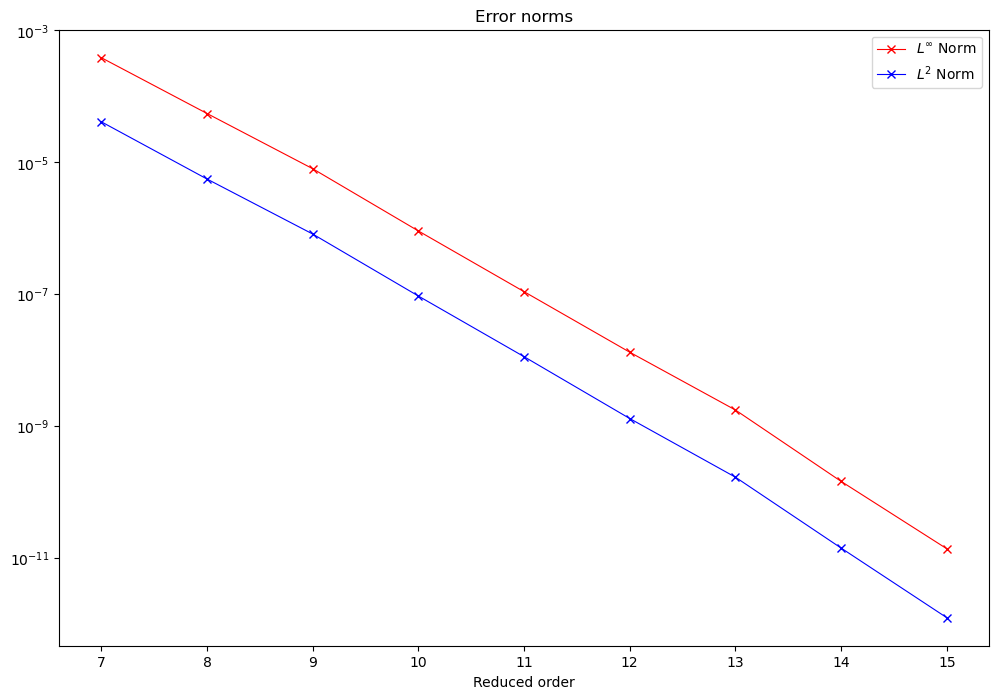

In [68]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.semilogy(order_list[6:], linf_list[6:], label = r"$L^\infty$ Norm", color='red', lw = 0.8, marker = 'x')
ax.semilogy(order_list[6:], l2_list[6:], label = r"$L^2$ Norm", color='blue', lw = 0.8, marker = 'x')
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

#### Complex-valued training and validation set (A Vital Step for IRKA)
In this subsection, we will examine the Matrix Reduction method using a complex-valued training set and validation set for complex parameters. For the IRKA method, we need to compute matrices at complex-valued interpolation points, and we will check if it works for complex parameters as well. As an example, we will use `penzl_example` from `pymor.models.examples`.

In [69]:
from pymor.parameters.base import Mu

# Create a complex-valued training set
card_training_set = 40
complex_parameters = 10*np.random.random_sample((card_training_set,)) + 10*1j*np.random.random_sample((card_training_set,))
imaginary_training_set = []
for i in range(card_training_set):
    imaginary_training_set.append(Mu({'s': np.array(complex_parameters[i])}))

# Create a complex-valued validation set
card_validation_set = 10
complex_parameters_validation = 15*np.random.random_sample((card_training_set,)) + 15*1j*np.random.random_sample((card_training_set,))
imaginary_validation_set = []
for k in range(10):
    imaginary_validation_set.append(Mu({'s': np.array(complex_parameters_validation[k])}))
print(f'An complex-valued training set is {imaginary_training_set}.')
print(f'An complex-valued validation set is {imaginary_validation_set}.')

An complex-valued training set is [Mu({'s': array([2.89961947+2.19285092j])}), Mu({'s': array([6.77536362+4.56612458j])}), Mu({'s': array([7.65118955+5.46082733j])}), Mu({'s': array([8.41166922+9.98193053j])}), Mu({'s': array([9.18947825+6.48937249j])}), Mu({'s': array([8.76824482+2.73202433j])}), Mu({'s': array([3.16557917+1.65097201j])}), Mu({'s': array([1.12680522+9.70483217j])}), Mu({'s': array([8.64309037+2.36352696j])}), Mu({'s': array([0.35607209+9.30792865j])}), Mu({'s': array([7.83385361+2.31447798j])}), Mu({'s': array([4.39898368+5.48649144j])}), Mu({'s': array([2.70725851+2.5733339j])}), Mu({'s': array([3.33458823+7.16113927j])}), Mu({'s': array([9.33356979+5.77747985j])}), Mu({'s': array([0.79636471+7.8150011j])}), Mu({'s': array([9.8410274+1.09553016j])}), Mu({'s': array([2.44900992+4.99593086j])}), Mu({'s': array([5.42547481+4.99301549j])}), Mu({'s': array([8.72216863+6.25582605j])}), Mu({'s': array([5.2268895+6.23727123j])}), Mu({'s': array([5.53615474+0.42723365j])}), M

In [70]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B)

A = penzl.A
B = penzl.B

# Reduced solution
reduced_order = 15
[reduced_solution, pod_reductor] = MatrixReductor(A, B, imaginary_training_set, imaginary_validation_set, reduced_order = reduced_order)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

# Reconstructed high-dimensional NumPy array (necessary for error analysis)
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
#reduced_solution_reconstruct_numpy
reduced_solution_reconstruct

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

NumpyVectorArray(
    NumpyVectorSpace(1006),
    [[ 0.10886521+1.56966994e-03j -0.08927957+2.35234137e-03j
       0.05234726+4.51363875e-04j ...  0.00099317-1.99089560e-06j
       0.00099218-1.98694690e-06j  0.0009912 -1.98300994e-06j]
     [ 0.11415519+7.98801455e-03j -0.08423455+1.49694581e-02j
       0.05359457+2.54280594e-03j ...  0.00098834-1.18090381e-05j
       0.00098736-1.17857300e-05j  0.00098639-1.17624909e-05j]
     [ 0.10947854+8.56845675e-03j -0.09110302+1.23990712e-02j
       0.05229368+2.40922162e-03j ...  0.00099397-1.04977934e-05j
       0.00099298-1.04769556e-05j  0.00099199-1.04561797e-05j]
     ...
     [ 0.11241641+4.17744791e-03j -0.08434083+7.59274925e-03j
       0.05333041+1.31648105e-03j ...  0.00098892-6.09094008e-06j
       0.00098795-6.07891096e-06j  0.00098697-6.06691745e-06j]
     [ 0.10442698+1.12634973e-03j -0.09517537+1.35701857e-03j
       0.05113303+2.97427837e-04j ...  0.00099837-1.24543830e-06j
       0.00099737-1.24295521e-06j  0.00099638-1.24047

In [71]:
# Converting matrices to numpy arrays
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in imaginary_validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

# Exact solution
exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# Data
reduced_order_error = 15
order_list = np.arange(1, reduced_order_error + 1)
linf_list = np.zeros(reduced_order_error)
l2_list = np.zeros(reduced_order_error)
for i in range(reduced_order_error):
    [reduced_solution, pod_reductor] = MatrixReductor(A, B, imaginary_training_set, imaginary_validation_set, reduced_order = i)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

### Hooray!🎉 It also seems to handle complex parameters

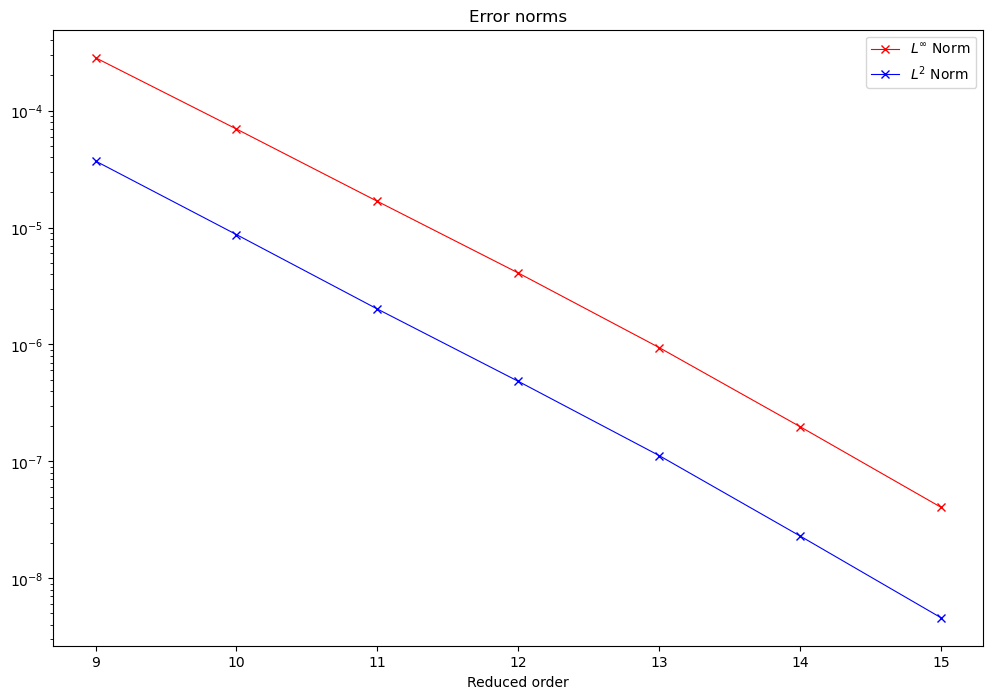

In [72]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.semilogy(order_list[8:], linf_list[8:], label = r"$L^\infty$ Norm", color='red', lw = 0.8, marker = 'x')
ax.semilogy(order_list[8:], l2_list[8:], label = r"$L^2$ Norm", color='blue', lw = 0.8, marker = 'x')
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

### Implementation of Matrix Reduction to IRKA (Single Input Single Output)
Consider some initial interpolation data $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i}$ for $0 < r \leq n$. Here, we construct the projection matrices $V$ and $W$ as follows:

\begin{equation*}
    V = [(-\mu_{1}I_{n} - A)^{-1}B\hat{b}_{1} \quad (-\mu_{2}I_{n} - A)^{-1}B\hat{b}_{2} \quad \cdots \quad (-\mu_{r}I_{n} - A)^{-1}B\hat{b}_{r}], \quad \text{and} \quad W = [(-\mu_{1}I_{n} - A)^{-*}C^{T}\hat{c}_{1} \quad (-\mu_{2}I_{n} - A)^{-*}C^{T}\hat{c}_{2}\quad \cdots \quad (-\mu_{r}I_{n} - A)^{-*}C^{T}\hat{c}_{r}] \quad \text{for } i = 1,\ldots,r,
\end{equation*}
where $r$ is the desired order of approximating ROM. 

### Defining Functions for Matrix Reduction in IRKA

Here, we will revisit and refine everything we have covered so far. Notice that we have written a `MatrixModel` function and a `MatrixReductor` only for the first linear coercive model. However, we need these functions for both models. Below, we explicitly redefine these functions for both cases. Additionally, we introduce a new function called `ProjectionMatrices`, which provides the projection matrices $V$ and $W$ required for IRKA. This function will streamline the process, making it sufficient to call it directly for use in IRKA.


In [256]:
def MatrixModel(A, B, C):
    '''
    This function creates stationary models for the following linear coercive models derived for the given three matrices A, B, and C:
    
        a_1(v, w; s) = w*(sI_n - A)v and l_1(w) = w*B
        a_2(v, w; s) = w*(sI_n - A)*v and l_2(w) = w*C^T.

    Inputs:
    ------------------------------------------------
    A - matrix -> NumPy array or NumpyMatrixOperator
    B - vector -> NumPy array or NumpyMatrixOperator
    C - vector -> NumPy array or NumpyMatrixOperator
    ------------------------------------------------
    Outputs:
    ------------------------------------------------
    model_V - Stationary Model of linear coercive model w*(sI_n - A)v = w*B -> StationaryModel
    model_W - Stationary Model of linear coercive model w*(sI_n - A)*v -> StationaryModel
    '''

    # Define operators (and also a dimension of a model)
    if isinstance(A, np.ndarray):
        dim = A.shape[0]
        A_op = NumpyMatrixOperator(A)
    else:
        dim = to_matrix(A).shape[0]
        A_op = A

    if isinstance(B, np.ndarray):
        B_op = NumpyMatrixOperator(B) 
    else:
        B_op = B  

    if isinstance(C, np.ndarray):
        C_op = NumpyMatrixOperator(C.T)  
    else:
        C_op = C.H  # C is real, so adjoint is transpose

    I_op = NumpyMatrixOperator(np.eye(dim))
    
    # Define parameter functional for 's'
    s_param = ProjectionParameterFunctional('s', 1)

    # Define bilinear form a(v, w; s) = w*(sI - A)v
    a_op_1 = LincombOperator([I_op, A_op], [s_param, -1])

    # Define bilinear form a(v, w; s) = w*(sI - A)*v -> Note: (sI - A)* = s*I - A*
    a_op_2 = LincombOperator([I_op, A_op.H], [ConjugateParameterFunctional(s_param), -1])
    
    # Define linear functional l(w) = w^*B
    l_op_1 = B_op

    # Define linear functional l(w) = w^*C^{T}
    l_op_2 = C_op

    # Define the StationaryModels
    model_V = StationaryModel(operator=a_op_1, rhs=l_op_1)
    model_W = StationaryModel(operator=a_op_2, rhs=l_op_2)

    return [model_V, model_W] 


In [257]:
def MatrixReductor(A, B, C, training_set, validation_set, reduced_order_V: int, reduced_order_W: int, reconstruct: bool = False):
    
    '''
    Inputs:
    ------------------------------------------------
    A - matrix -> NumPy array or NumpyMatrixOperator
    B - vector -> NumPy array or NumpyMatrixOperator
    C - vector -> NumPy array or NumpyMatrixOperator
    training_set - an array containing parameters used to construct the snapshot matrix -> type(training_set[i]) = pymor.parameters.base.Mu (list of Mu objects)
    validation_set - an array containing parameters used to evaluate the reduced model after its construction -> type(validation_set[i]) = pymor.parameters.base.Mu (list of Mu objects)
    reduced_order_V - order of the reduced model for the first coercive model -> int
    reduced_order_W - order of the reduced model for the second coercive model -> int
    reconstruct - If 'True', the reconstructed reduced solutions for both coercive models will be output; otherwise, the reduced solutions for both coercive models and the reductors for both reduced models will be returned -> bool
    ------------------------------------------------
    Outputs:
    ------------------------------------------------
    reduced_solution_reconstruct_V -> NumpyVectorArray
    reduced_solution_reconstruct_W -> NumpyVectorArray
    reduced_solution_V -> NumpyVectorArray
    reduced_solution_W -> NumpyVectorArray
    pod_reductor_V -> StationaryRBReductor
    pod_reductor_W -> StationaryRBReductor
    '''

    # Construct Matrix induced StationaryModels
    [model_V, model_W] = MatrixModel(A, B, C)

    # Compute FOM solutions for the parameters in the training set
    solution_snapshots_V = model_V.solution_space.empty()
    solution_snapshots_W = model_W.solution_space.empty()
    for s in training_set:
        solution_snapshots_V.append(model_V.solve(s))
        solution_snapshots_W.append(model_W.solve(s))
        
    # Snapshot matrices
    snapshot_matrix_V = solution_snapshots_V.to_numpy().T # Note: One may also use solution_snapshots_V.impl._array.T to get np.ndarray type needed for computation
    snapshot_matrix_W = solution_snapshots_W.to_numpy().T

    # Finding the Singular Value Decomposition (SVD) of snapshot matrices -> S = UΣV^T
    U_V, D_V, Vt_V = np.linalg.svd(snapshot_matrix_V, full_matrices = True)
    U_W, D_W, Vt_W = np.linalg.svd(snapshot_matrix_W, full_matrices = True)

    if reduced_order_V > min(snapshot_matrix_V.shape):
        raise ValueError("'reduced_order_V' cannot exceed the rank of the snapshot matrix.")
    if reduced_order_W > min(snapshot_matrix_W.shape):
        raise ValueError("'reduced_order_W' cannot exceed the rank of the snapshot matrix.")

    # The reduced bases (POD bases)
    pod_basis_numpy_V = U_V[:,:reduced_order_V]
    pod_basis_numpy_W = U_W[:,:reduced_order_W]

    # Convert NumPy array into VectorArray 
    space_V = NumpyVectorSpace(model_V.order) #number of columns = model_V.order
    space_W = NumpyVectorSpace(model_W.order)
    pod_basis_V = space_V.make_array(pod_basis_numpy_V.T) #This is actually transpose of POD-RB basis
    pod_basis_W = space_W.make_array(pod_basis_numpy_W.T) #This is actually transpose of POD-RB basis
    
    # POD-Galerkin RB method
    pod_reductor_V = StationaryRBReductor(model_V, RB = pod_basis_V) 
    pod_reductor_W = StationaryRBReductor(model_W, RB = pod_basis_W) 
    pod_rom_V = pod_reductor_V.reduce()
    pod_rom_W = pod_reductor_W.reduce()

    # Solution arrays containing len(validation_set) many reduced samples
    card_validation = len(validation_set)
    reduced_solution_V = pod_rom_V.solution_space.empty()
    reduced_solution_W = pod_rom_W.solution_space.empty()
    for s in validation_set:
        reduced_solution_V.append(pod_rom_V.solve(s))
        reduced_solution_W.append(pod_rom_W.solve(s))
        
    # It would be better to get matrices where columns are the reconstructed reduced solutions as in theory we will use such matrix; however PyMor only has vstack option (appending as a row of a matrix)
    reduced_solution_reconstruct_V_T = pod_reductor_V.reconstruct(reduced_solution_V) # a matrix with rows representing the reconstructed reduced solutions for different parameter values to first parametrized coercive model (row i will give us (s_{i}I - A)^{-1}B)
    reduced_solution_reconstruct_W_T = pod_reductor_W.reconstruct(reduced_solution_W) # a matrix with rows representing the reconstructed reduced solutions for different parameter values to second parametrized coercive model (row i will give us (s_{i}I - A)^{-*}C^T)

    # To align with the theory, we take the transpose of the result. Also, note that the transpose operation does not exist in PyMor for `NumpyVectorArray`, so we first take the transpose of the NumPy array and then convert it back
    space_V_numpy = NumpyVectorSpace(card_validation)
    space_W_numpy = NumpyVectorSpace(card_validation)
    reduced_solution_reconstruct_V = space_V_numpy.make_array(reduced_solution_reconstruct_V_T.to_numpy().T)
    reduced_solution_reconstruct_W = space_W_numpy.make_array(reduced_solution_reconstruct_W_T.to_numpy().T)
    
    if reconstruct is True:
        return [reduced_solution_reconstruct_V, reduced_solution_reconstruct_W]
    else:
        return [reduced_solution_V, reduced_solution_W, pod_reductor_V, pod_reductor_W]

Let $A\in\mathbb{R}^{n\times n}$ $B\in\mathbb{R}^{n\times 1}$ $C\in\mathbb{R}^{1\times n}$ be given. If one uses `MatrixReductor(A, B, C, training_set, validation_set, reduced_order_V=N, reduced_order_W=M, reconstruct=True)`, then the outputs are `reduced_solution_reconstruct_V = R^{V}_N(s)` and `reduced_solution_reconstruct_W = R^{W}_M(s)`, which are given as:
\begin{equation*}
R^{V}_N(s) = 
\begin{bmatrix}
\hat{v}_{N}(s_{1}) & \hat{v}_{N}(s_{2}) &  \cdots  &\hat{v}_{N}(s_{r})
\end{bmatrix}
\quad \text{and} \quad
R^{W}_M(s) = 
\begin{bmatrix}
\hat{w}_{M}(s_{1}) & \hat{w}_{M}(s_{2}) & \cdots & \hat{w}_{M}(s_{r})
\end{bmatrix},
\end{equation*}
where $\hat{v}_{N}(s_{i})\in\mathbb{C}^{n\times 1}$ and $\hat{w}_{M}(s_{i})\in\mathbb{C}^{n\times 1}$ are the reconstructed solutions of the reduced solutions $v_{N}(s_{i})\in\mathbb{C}^{N\times 1}$ and $w_{M}(s_{i})\in\mathbb{C}^{M\times 1}$ with reduction orders $N$ and $M$, respectively, for the following (parameter-separable) parameterized linear coercive models (FOM) evaluated at a given parameter $s_{i}$.
\begin{align*}
    a_{1}(v, u; s) = l_{1}(u) \quad v, u\in \mathbb{C}^{n\times 1}\\
    a_{2}(w, u; s) = l_{2}(u) \quad w, u\in \mathbb{C}^{n\times 1}
\end{align*}
where $a_{1}(v, u; s) = u^{*}(sI_{n} - A)v\in \mathbb{C}$ and $l_{1}(u) = u^{*}B$, and $a_{2}(w, u; s) = u^{*}(sI_{n} - A)^{*}w\in \mathbb{C}$ and $l_{2}(u) = u^{*}C^{T}$, and solutions to these parametrized linear coercive models are
\begin{equation*}
    v(s) = (sI_{n} - A)^{-1}B \quad \text{and} \quad w(s) = (sI_{n} - A)^{-*}C^{T}.
\end{equation*}
Consider some initial interpolation data $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i}\in\mathbb{C}$ for $0 < r \leq n$. Therefore, the POD-projection matrices are given by
\begin{equation*}
    V_{POD}= 
    \begin{bmatrix}
    \hat{v}_{N}(-\mu_{1})\hat{b}_{1}&\hat{v}_{N}(-\mu_{2})\hat{b}_{2}&\cdots&\hat{v}_{N}(-\mu_{r})\hat{b}_{r}
    \end{bmatrix} = R^{V}_N(\mu)D_{\hat{b}} \quad \text{and} \quad
    W_{POD} = 
    \begin{bmatrix}
    \hat{w}_{N}(-\mu_{1})\hat{c}_{1}&\hat{w}_{N}(-\mu_{2})\hat{c}_{2}&\cdots&\hat{w}_{N}(-\mu_{r})\hat{c}_{r}
    \end{bmatrix} = R^{W}_M(\mu)D_{\hat{c}},
\end{equation*}
where $\mu = (-\mu_{1}, -\mu_{2},\ldots, -\mu_{r})$ and 
\begin{equation*}
    D_{\hat{b}} = diag(\hat{b}_{1}, \hat{b}_{2}, \ldots, \hat{b}_{r}) \quad \text{and} \quad D_{\hat{c}} = diag(\hat{c}_{1}, \hat{c}_{2}, \ldots, \hat{c}_{r}).
\end{equation*}   
This observation provides us with a fairly good error estimate for the projection matrices.
\begin{align*}
    \lVert V - V_{POD}\rVert &= \lVert R^{V}(\mu)D_{\hat{b}} - R^{V}_N(\mu)D_{\hat{b}}\rVert = \lVert (R^{V}(\mu) - R^{V}_N(\mu))D_{\hat{b}}\rVert \leq \lVert D_{\hat{b}}\rVert \cdot \lVert R^{V}(\mu) - R^{V}_N(\mu)\rVert,\\
    \lVert W - W_{POD}\rVert &= \lVert R^{W}(\mu)D_{\hat{c}} - R^{W}_M(\mu)D_{\hat{c}}\rVert = \lVert (R^{W}(\mu) - R^{W}_M(\mu))D_{\hat{c}}\rVert \leq \lVert D_{\hat{c}}\rVert \cdot \lVert R^{W}(\mu) - R^{W}_M(\mu)\rVert.
\end{align*}  
This demonstrates that if $\lVert R^{V}(\mu) - R^{V}_N(\mu) \rVert$ and $\lVert R^{W}(\mu) - R^{W}_M(\mu) \rVert \to 0$ as $N, M \to n$, then $\lVert V - V_{POD} \rVert$ and $\lVert W - W_{POD} \rVert\to 0$.

In [258]:
def ProjectionMatrices(A, B, C, mu, b, c, training_set, reduced_order_V: int, reduced_order_W: int):

    '''
    Inputs:
    ------------------------------------------------
    A - matrix -> NumPy array or NumpyMatrixOperator -> A.shape = (n, n)
    B - (column) vector -> NumPy array or NumpyMatrixOperator -> B.shape = (n, 1)
    C - (row) vector -> NumPy array or NumpyMatrixOperator -> C.shape = (1, n)
    mu - list of -mu_i values -> type(mu[i]) = pymor.parameters.base.Mu (list of Mu objects)
    b - NumPy array -> b.shape = (r,) where r = len(mu)
    c - NumPy array -> c.shape = (r,) where r = len(mu)
    training_set
    reduced_order_V - matrix reduction order for the first model -> int
    reduced_order_W - matrix reduction order for the second model -> int
    ------------------------------------------------
    Outputs:
    ------------------------------------------------
    V - projection matrix V -> NumpyVectorArray -> V.shape = (n, r)
    W - projection matrix W -> NumpyVectorArray -> W.shape = (n, r)
    '''

    [R_V, R_W] = MatrixReductor(A = A, B = B, C = C, training_set = training_set, validation_set = mu, reduced_order_V = reduced_order_V, reduced_order_W = reduced_order_W, reconstruct = True)

    R_V, R_W = R_V.to_numpy(), R_W.to_numpy() # Note: One may also use R_V.impl._array to get np.ndarray type needed for computation
    D_b, D_c = np.diag(b), np.diag(c)

    V_numpy = np.matmul(R_V, D_b)
    W_numpy = np.matmul(R_W, D_c)

    space = NumpyVectorSpace(V_numpy.shape[1])
    V = space.make_array(V_numpy)
    W = space.make_array(W_numpy)

    return [V, W]

In [259]:
def error(A, B, C, mu, b, c, V_pod, W_pod, norm):
    
    '''
    Inputs:
    ------------------------------------------------
    A - matrix -> NumPy array or NumpyMatrixOperator -> A.shape = (n, n)
    B - (column) vector -> NumPy array or NumpyMatrixOperator -> B.shape = (n, 1)
    C - (row) vector -> NumPy array or NumpyMatrixOperator -> C.shape = (1, n)
    mu - list of -mu_i values -> type(mu[i]) = pymor.parameters.base.Mu (list of Mu objects)
    b - NumPy array -> b.shape = (r,) where r = len(mu)
    c - NumPy array -> c.shape = (r,) where r = len(mu)
    V_pod - POD-projection matrix V -> NumpyVectorArray -> V.shape = (n, r)
    W_pod - POD-projection matrix W -> NumpyVectorArray -> V.shape = (n, r)
    norm - see 'https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html' for eight different matrix norms
    ------------------------------------------------
    Output:
    ------------------------------------------------
    error - [||V_exact - V_POD||_{norm}, ||W_exact - W_POD||_{norm}] -> list of floats
    '''
    
    dim = A.shape[0] if isinstance(A, np.ndarray) else to_matrix(A).shape[0]
    
    # NumPy convertions
    A = A if isinstance(A, np.ndarray) else to_matrix(A).toarray()
    B = B if isinstance(B, np.ndarray) else to_matrix(B)
    C = C if isinstance(C, np.ndarray) else to_matrix(C)
    mu_values = np.array([s['s'] for s in mu]) 
    V_pod_numpy, W_pod_numpy = V_pod.to_numpy(), W_pod.to_numpy()
    
    # Exact projection matrices
    identity = np.eye(dim)
    D_b, D_c = np.diag(b), np.diag(c)
    
    V_exact = np.matmul(np.hstack([np.matmul(inv(s*identity - A), B) for s in mu_values]), D_b)
    W_exact = np.matmul(np.hstack([(np.matmul(np.conjugate(inv(s*identity - A).T), C.T)) for s in mu_values]), D_c)

    # Computing error norms
    error_V = np.linalg.norm(V_exact - V_pod_numpy, norm)
    error_W = np.linalg.norm(W_exact - W_pod_numpy, norm)

    return [error_V, error_W]   

## Caution!
Note that for the MIMO case, an error arises when we construct the StationaryModel because `rhs.source.is_scalar` is False. This occurs because $v$ and $w$ are matrices, not vectors.

In [261]:
# Defining matrices
n = 150
m = 3 # number of inputs
p = 4 # number of outputs

# A: n x n matrix with normal distribution
np.random.seed(10)
A = np.random.normal(size = (n,n)) 

# B: n x m matrix with normal distribution
np.random.seed(25)
B = np.random.normal(size = (n,m))

# C: p x n matrix with normal distribution
np.random.seed(45)
C = np.random.normal(size = (p,n))

In [262]:
MatrixModel(A, B, C)

AssertionError: 

#### Remedy
The right question would be whether it is possible to split the model into submodels with `rhs.source.is_scalar = True`, or in other words, into models with \( m = p = 1 \). In this context, one would need to check if it is possible to partition the MIMO model into SISO models. It turns out that this is indeed possible, and several methodologies exist for doing so. One commonly used method to split a MIMO model into SISO models is Singular Value Decomposition (SVD). In this discussion, we will not focus on the MIMO case, as SVD can be employed to obtain several SISO models, and we can apply the method we proposed for each individual SISO.

### Examples
Here, we consider the case where $A \in \mathbb{R}^{n \times n}$, $B \in \mathbb{R}^{n \times 1}$, and $C \in \mathbb{R}^{1 \times n}$. Additionally, the interpolation data $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i} \in \mathbb{C}$ for $0 < r \leq n$, applicable to both real and complex values, is presented below.

In [263]:
from pymor.models.examples import penzl_example

penzl = penzl_example()

[model_penzl_V,_] = MatrixModel(penzl.A, penzl.B, penzl.C)

A = penzl.A
B = penzl.B
C = penzl.C
b = 3*np.random.rand(10)
c = 7*np.random.rand(10)
parameter_space = model_penzl_V.parameters.space(0.01, 10.)
training_set = parameter_space.sample_randomly(30)
validation_set = parameter_space.sample_randomly(10)

[V, W] = ProjectionMatrices(A = A, B = B, C = C, mu = validation_set, b = b, c = c, training_set = training_set, reduced_order_V = 15, reduced_order_W = 15)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [264]:
# Use error function defined above
linf = error(A = A, B = B, C = C, mu = validation_set, b = b, c = c, V_pod = V, W_pod = W, norm = np.inf)
l2 = error(A = A, B = B, C = C, mu = validation_set, b = b, c = c, V_pod = V, W_pod = W, norm = 2)
print(f'The Linf norm of V - V_POD is {linf[0]} and W - W_POD is {linf[1]}.')
print(f'The L2 norm of V - V_POD is {l2[0]} and W - W_POD is {l2[1]}.')

The Linf norm of V - V_POD is 1.8457457784393227e-14 and W - W_POD is 4.957145804951324e-14.
The L2 norm of V - V_POD is 1.1570551073915226e-14 and W - W_POD is 2.887724101011227e-14.


In [276]:
from pymor.parameters.base import Mu
from pymor.models.examples import penzl_example

penzl = penzl_example()

A = penzl.A
B = penzl.B
C = penzl.C

# Create a complex-valued training set
card_training_set = 80
complex_parameters = -10*np.random.random_sample((card_training_set,)) + 10*1j*np.random.random_sample((card_training_set,))
imaginary_training_set = []
for i in range(card_training_set):
    imaginary_training_set.append(Mu({'s': np.array(complex_parameters[i])}))

# Create a complex-valued mu set
card_validation_set = 10
complex_parameters_validation = 15*np.random.random_sample((card_training_set,)) + 15*1j*np.random.random_sample((card_training_set,))
imaginary_validation_set = []
for k in range(10):
    imaginary_validation_set.append(Mu({'s': np.array(complex_parameters_validation[k])}))

b = 7*np.random.random_sample((card_validation_set,)) + 10*1j*np.random.random_sample((card_validation_set,))
c = 5*np.random.random_sample((card_validation_set,)) + 10*1j*np.random.random_sample((card_validation_set,))

[V_penzl, W_penzl] = ProjectionMatrices(A = A, B = B, C = C, mu = imaginary_validation_set, b = b, c = c, training_set = imaginary_training_set, reduced_order_V = 40, reduced_order_W = 40)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [277]:
# Use error function defined above
linf_penzl = error(A = A, B = B, C = C, mu = imaginary_validation_set, b = b, c = c, V_pod = V_penzl, W_pod = W_penzl, norm = np.inf)
l2_penzl = error(A = A, B = B, C = C, mu = imaginary_validation_set, b = b, c = c, V_pod = V_penzl, W_pod = W_penzl, norm = 2)
print(f'The Linf norm of V - V_POD is {linf_penzl[0]} and W - W_POD is {linf_penzl[1]}.')
print(f'The L2 norm of V - V_POD is {l2_penzl[0]} and W - W_POD is {l2_penzl[1]}.')

The Linf norm of V - V_POD is 1.249253246045189e-08 and W - W_POD is 5.75626823914447e-09.
The L2 norm of V - V_POD is 2.4395036438667103e-08 and W - W_POD is 1.1402930547550923e-08.


## Important note